## Google Cirq qcnn example

This notebook shows how to use the `quantum_estimators` package to generate Quantum Convolutional Neural Networks (QCNNs) using [cirq](https://quantumai.google/cirq) and [tensorflow quantum](https://www.tensorflow.org/quantum/overview). The package implements the QCNN as a [keras layer](https://keras.io/api/layers/) that contains logic for generating it's circuit architecture via hyperparamaters while managing the variational circuit paramaters. It's imported as follows: `from quantum_estimators import Qcnn_cirq as Qcnn`. 

The example shown is a binary classification model that distinguishes between two musical genres using the well known GTZAN dataset.

In [1]:
# Load libraries
import sympy
import numpy as np
from collections import namedtuple
import pandas as pd
import cirq
import tensorflow as tf
import tensorflow_quantum as tfq
from tensorflow import keras
from sklearn.model_selection import train_test_split

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt

2022-08-17 00:13:02.426816: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-17 00:13:02.426852: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-17 00:13:03.787992: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-17 00:13:03.788057: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-17 00:13:03.788127: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Enigma): /proc/driver/nvidia/version does not exist
2022-08-17 00:13:03.788442: I tensorflow/core/platform/cpu_feature_gua

### Experimental setup

The dataset contains statistics from 1000 audio tracks, each being a 30-second recording of some song. Each song is given a label of one of the following ten musical genres: **blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, rock**. See [marsyas](https://github.com/marsyas/website/blob/master/downloads/data-sets.rst) and [kaggle](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification) for more info.

We'll build a model to distinguish **rock** from **reggae**

In [2]:
# Specify data path
path = "../data/gtzan_30s_stats.csv"
# Specify genres to build classification model from, options are:
# blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, rock 
target_pair = ["rock", "reggae"]
# Read data
raw = pd.read_csv(path)
raw.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [3]:
# Specify target column
target = "label"
# Specify columns to remove
columns_to_remove = ["filename", "length", target]

For the data cleaning component we split the data into a test and train set and remove unnecesary columns. 

In [4]:
# Seperate X (features) and y (target) from dataset
y = raw.loc[:, target]
X = raw.drop(columns_to_remove, axis=1)
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
)
# Use a named typle to keep track of the changes to train and test samples
Samples = namedtuple("Samples", ["X_train", "y_train", "X_test", "y_test"])
# samples_raw is an instance of Samples, containing the raw samples
# access train features by samples_raw.X_train
samples_raw = Samples(X_train, y_train, X_test, y_test)

Next we filter out all genres except those specified by `target_pair`.

In [5]:
# Filter out unneccesary data, only store songs with labels specified in target_pair
train_filter = np.where(
    (samples_raw.y_train == target_pair[0]) | (samples_raw.y_train == target_pair[1])
)
test_filter = np.where(
    (samples_raw.y_test == target_pair[0]) | (samples_raw.y_test == target_pair[1])
)
X_train_filtered, X_test_filtered = (
    samples_raw.X_train.iloc[train_filter],
    samples_raw.X_test.iloc[test_filter],
)
y_train_filtered, y_test_filtered = (
    samples_raw.y_train.iloc[train_filter],
    samples_raw.y_test.iloc[test_filter],
)
# Convert target to binary int values, (genre_1, genre_2)->(0,1)
y_train_filtered = np.where(y_train_filtered == target_pair[1], 1, 0)
y_test_filtered = np.where(y_test_filtered == target_pair[1], 1, 0)
# samples_filtered now contains the latest X, y train and test data
samples_filtered = Samples(
    X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered
)

### Preprocessing

**Feature Scaling and Selection**

Here we manually select $8$ features to build the model on and then scale them to range between $[0,\frac{\pi}{2}]$. The selection can be automated with strategies like PCA or tree based methods using [sklearn pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). Even though we just scale the data, the code is presented in such a way so that it's easy to add other pipeline steps.

In [6]:
# Specify features to build model on
features = ['mfcc2_var', 'mfcc3_var', 'mfcc4_var', 'mfcc5_var', 'mfcc7_var',
       'mfcc8_var', 'mfcc11_mean', 'mfcc13_mean']
X_train_selected = np.array(samples_filtered.X_train[features])
X_test_selected = np.array(samples_filtered.X_test[features])

samples_selected = Samples(
    X_train_selected, samples_filtered.y_train, X_test_selected, samples_filtered.y_test
)

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
# Create a pipeline_list which will contain preprocessing steps
pipeline_list = []
# For now we only scale the data, but more complicated pipelines can be constructed with this pattern
scaler = (
    "minmax",
    MinMaxScaler(feature_range=[0, np.pi / 2]),
)
pipeline_list.append(scaler)
pipeline = Pipeline(pipeline_list)
# Fit pipeline
pipeline.fit(samples_selected.X_train, samples_selected.y_train)
# Transform data
X_train_tfd = pipeline.transform(samples_selected.X_train)
X_test_tfd = pipeline.transform(samples_selected.X_test)
samples_tfd = Samples(
    X_train_tfd, samples_selected.y_train, X_test_tfd, samples_selected.y_test
)

### Encode data into a quantum state

In [8]:
def qubit_encoding(x, gate=cirq.rx):
    circuit = cirq.Circuit()
    for i, value in enumerate(x):
        qubit = cirq.LineQubit(i)
        circuit.append(gate(value).on(qubit))

    return circuit  

X_train_encoded = tfq.convert_to_tensor([qubit_encoding(x) for x in samples_tfd.X_train])
X_test_encoded = tfq.convert_to_tensor([qubit_encoding(x) for x in samples_tfd.X_test])

samples_encoded = Samples(
    X_train_encoded, samples_tfd.y_train, X_test_encoded, samples_tfd.y_test
)

### Build model

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


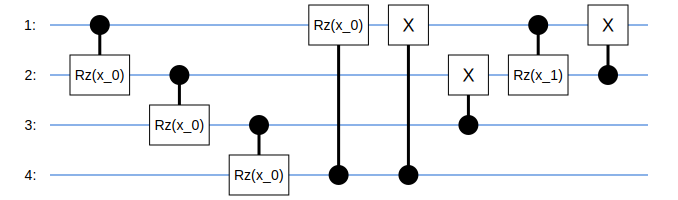

In [9]:
from quantum_estimators import Qcnn_cirq as Qcnn
from quantum_estimators import QConv, QPool, convert_graph_to_circuit_cirq, binary_tree_r, plot_graph
from cirq.contrib.svg import SVGCircuit

head_graph, _ = binary_tree_r(4)
circuit, symbols = convert_graph_to_circuit_cirq(head_graph)
SVGCircuit(circuit)

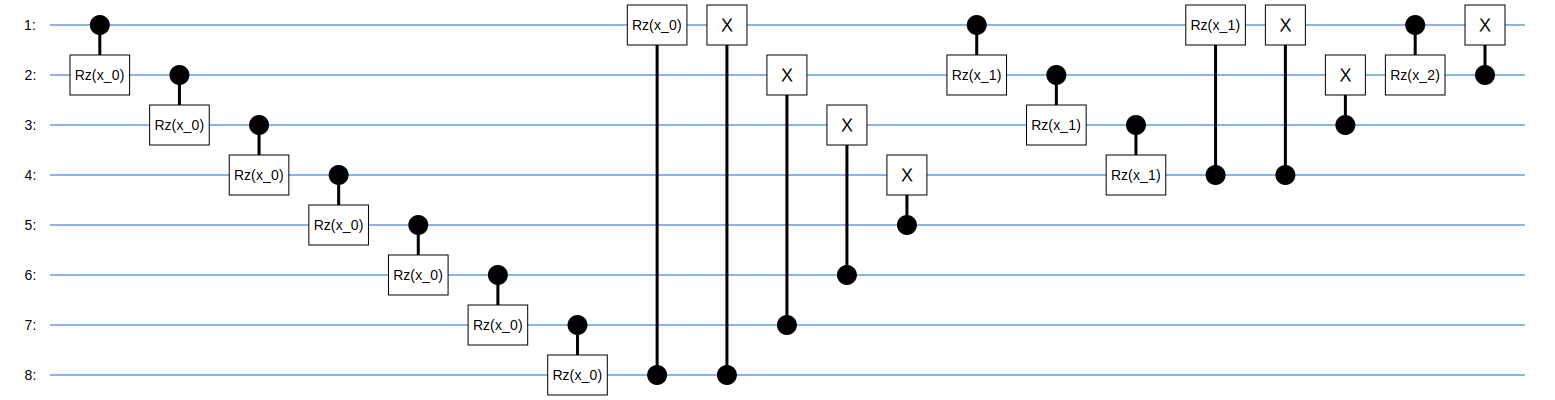

In [10]:
head_graph, _ = binary_tree_r(8, s_c=1, s_p=0, pool_filter="right")
# head_graph, _ = binary_tree_r(8, s_c=1, s_p=0, pool_filter="left")
# head_graph, _ = binary_tree_r(8, s_c=3, s_p=2, pool_filter="left")
# head_graph, _ = binary_tree_r(8, s_c=1, s_p=0, pool_filter="inside")
# head_graph, _ = binary_tree_r(8, s_c=1, s_p=0, pool_filter="outside")
circuit, symbols = convert_graph_to_circuit_cirq(head_graph)
SVGCircuit(circuit)

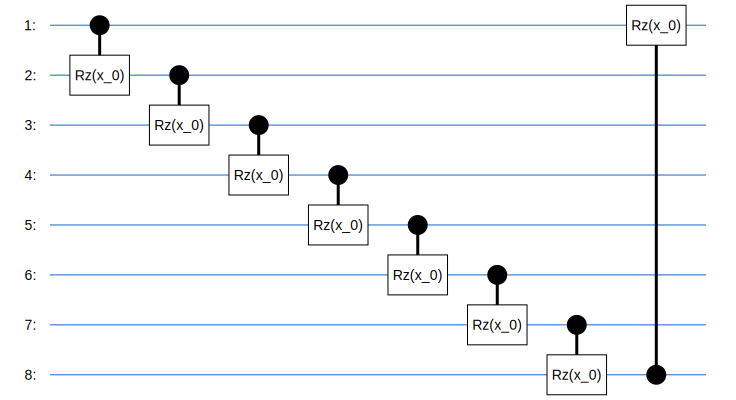

In [11]:
base = QConv(8)
# base = QConv(8, stride=3)
SVGCircuit(convert_graph_to_circuit_cirq(base)[0])

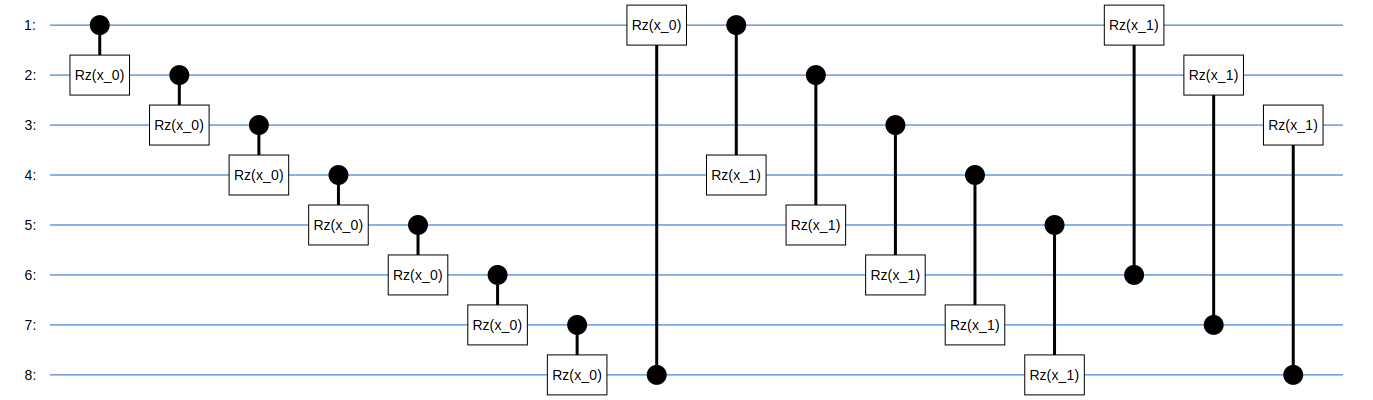

In [12]:
base = QConv(8)
QConv(base, stride=3)
# QConv(QPool(QConv(base, stride=3), pool_filter="11100000"))
SVGCircuit(convert_graph_to_circuit_cirq(base)[0])

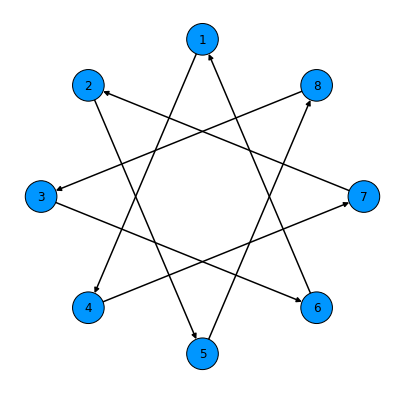

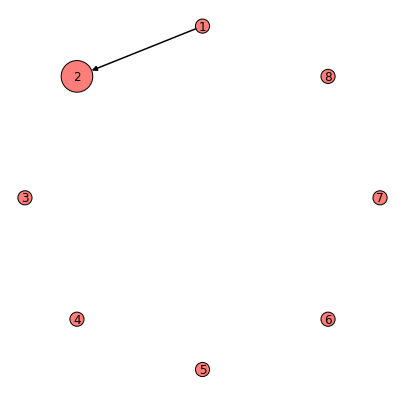

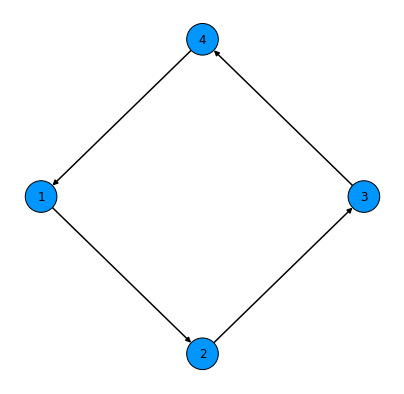

In [13]:
base = QConv(8, stride=3)
plot_graph(base)
# TODO plotting isn't correct yet
plot_graph(QPool(base,pool_filter="10000000"))
plot_graph(QConv(QPool(base), stride=5))
# plot_graph(QPool(QConv(QPool(base))))

In [14]:
# Default pooling circuit
def V(bits, symbols=None):
    circuit = cirq.Circuit()
    q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
    circuit += cirq.rz(symbols[0]).on(q1).controlled_by(q0)
    circuit += cirq.X(q0)
    circuit += cirq.rx(symbols[1]).on(q1).controlled_by(q0)
    return circuit


# Default convolution circuit
def U(bits, symbols=None):
    circuit = cirq.Circuit()
    q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
    circuit += cirq.rx(symbols[0]).on(q0)
    circuit += cirq.rx(symbols[1]).on(q1)
    circuit += cirq.rz(symbols[2]).on(q0)
    circuit += cirq.rz(symbols[3]).on(q1)
    circuit += cirq.rz(symbols[4]).on(q1).controlled_by(q0)
    circuit += cirq.rz(symbols[5]).on(q0).controlled_by(q1)
    circuit += cirq.rx(symbols[6]).on(q0)
    circuit += cirq.rx(symbols[7]).on(q1)
    circuit += cirq.rz(symbols[8]).on(q0)
    circuit += cirq.rz(symbols[9]).on(q1)
    return circuit

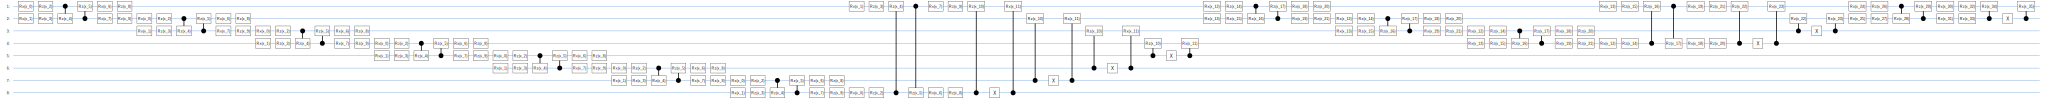

In [15]:
head_graph, _ = binary_tree_r(8, convolution_mapping={1:(U,10)}, pooling_mapping={1:(V,2)})
circuit, symbols = convert_graph_to_circuit_cirq(head_graph)
SVGCircuit(circuit)

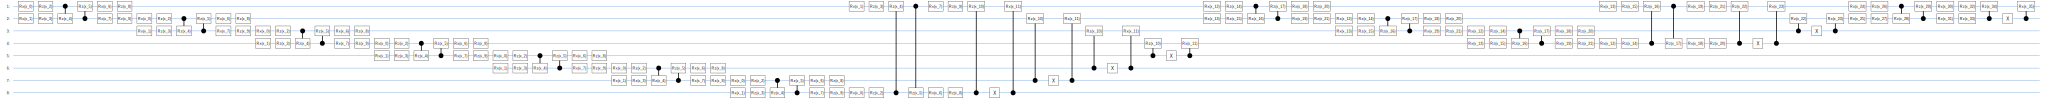

In [21]:
from quantum_estimators import Qcnn_cirq as Qcnn
from cirq.contrib.svg import SVGCircuit
qcnn = Qcnn()
# display default circuit and configuration
SVGCircuit(qcnn.circuit)

In [9]:
def U(bits, symbols=None):
    circuit = cirq.Circuit()
    q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
    # circuit += cirq.H(q0)
    # circuit += cirq.H(q1)
    circuit += cirq.rz(symbols[0]).on(q1).controlled_by(q0)
    # circuit += cirq.rz(symbols[1]).on(q0).controlled_by(q1)
    return circuit


def V(bits, symbols=None):
    circuit = cirq.Circuit()
    q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
    circuit += cirq.CNOT(q0, q1)
    return circuit

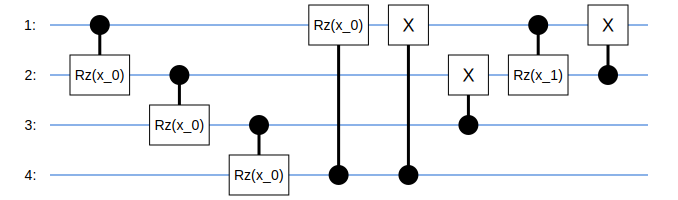

In [10]:
qcnn = Qcnn(n_q=4, s_c=1, s_p=0, pool_filter="right", convolution_mapping={1: (U, 1)}, pooling_mapping={1: (V, 0)})
SVGCircuit(qcnn.circuit)

Scale up model to 8 qubits, change convolution stride to $s_c=3$ 

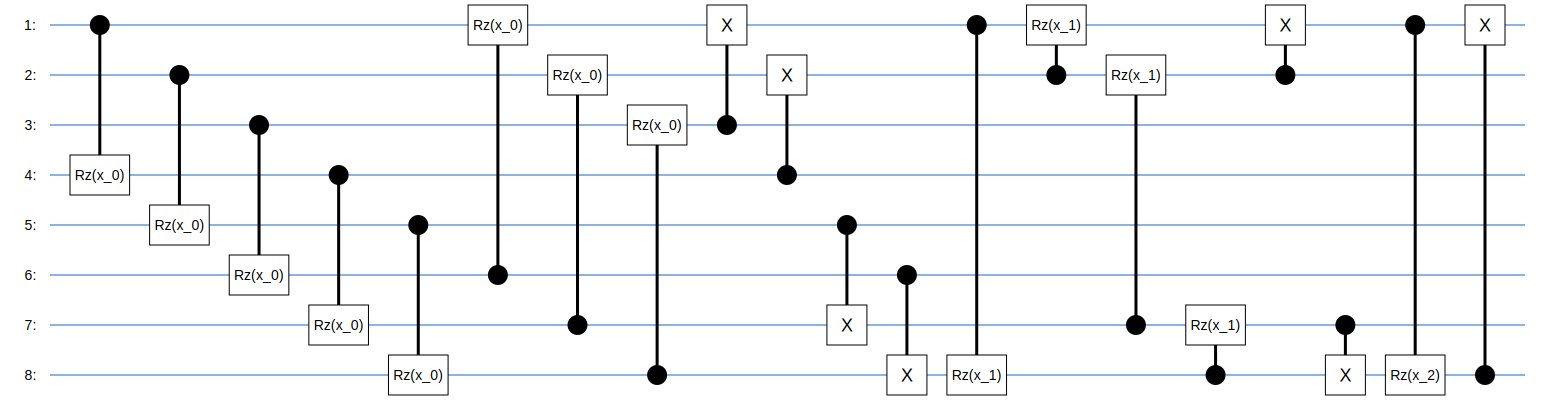

In [38]:
qcnn = Qcnn(n_q=8, s_c=3, s_p=0, pool_filter="inside", convolution_mapping={1: (U, 1)}, pooling_mapping={1: (V, 0)})
SVGCircuit(qcnn.circuit)

In [11]:
print(f"Readout qubit: {qcnn.readout}")
print(f"Measure gate: {qcnn.ops_gate}")
print(f"Number of qubits: {qcnn.n_q}")
print(f"Convolution stride s_c: {qcnn.s_c}")
print(f"Pooling stride s_p: {qcnn.s_p}")

Readout qubit: 1
Measure gate: Z
Number of qubits: 4
Convolution stride s_c: 1
Pooling stride s_p: 0


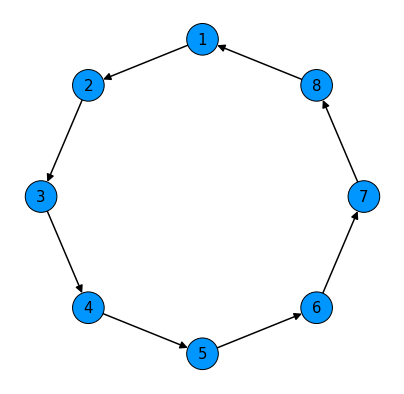

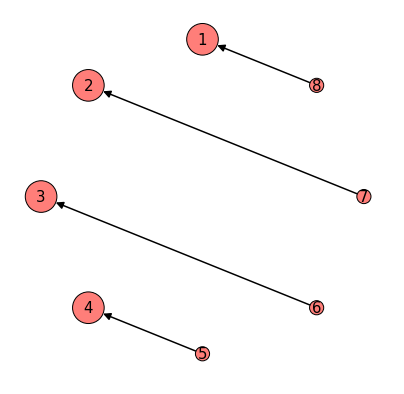

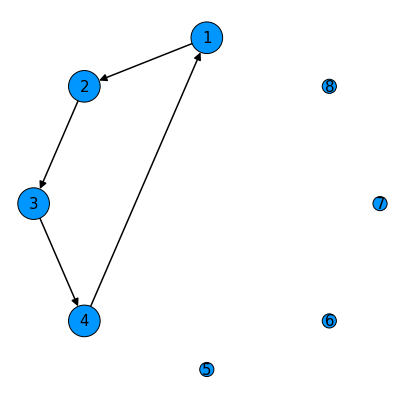

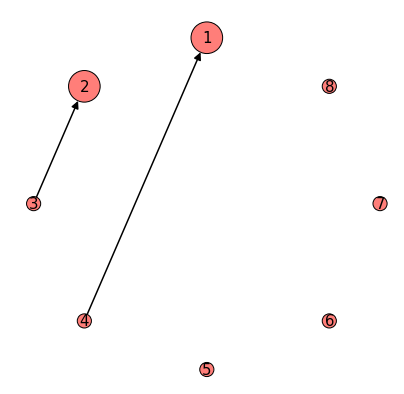

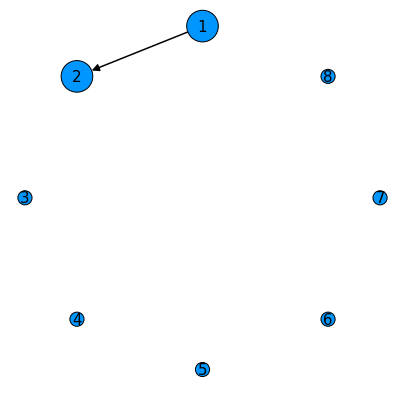

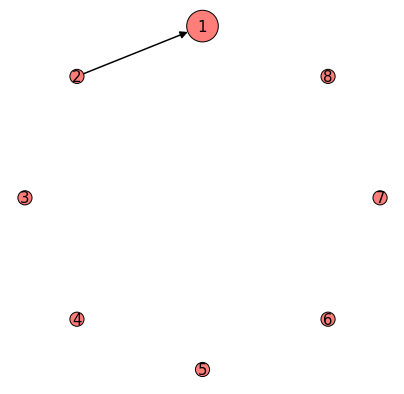

In [29]:
from quantum_estimators import plot_qcnn_graphs

figs = plot_qcnn_graphs(qcnn.graphs, arrowsize=15, font_size=15)

In [112]:
symbols

(x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9)

In [22]:
# === Specify hyperparamaters ===
# Number of qubits (since we're using qubit encoding ensure there is a one-one mapping between feature and qubit)
n_q = 8
# Convolution Stride
s_c = 5
# Pooling Stride
s_p = 0
# Pooling Filter, options: right, left, inside, outside, even, odd
pool_filter = "right"

head_graph, tail_graph = binary_tree_r(n_q=n_q, s_c=s_c, s_p=s_p, pool_filter=pool_filter, convolution_mapping={1:(U,10)}, pooling_mapping={1:(V,2)})
readout = readout = cirq.LineQubit(tail_graph.E[0][1])
circuit, symbols = convert_graph_to_circuit_cirq(head_graph)

model = tf.keras.Sequential(
        [
            # The Qcnn layer returns the expected value of the readout gate, range [-1,1]. By default readout is criq.Z and the model determines
            # which qubit to measure based on the one that's left over
            Qcnn(
                circuit=circuit,
                symbols=symbols,
                readout=readout
            ),
            # Convert expectation values to lie between 0 and 1
            tf.keras.layers.Rescaling(1.0 / 2, offset=.5),
        ]
    )

In [25]:
model.compile(
    optimizer="Adam",
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)],
)
# model.run_eagerly = True
model.fit(x=samples_encoded.X_train, y=samples_encoded.y_train, epochs=120)

Epoch 1/120
5/5 [==============================] - 0s 21ms/step - loss: 0.7292 - binary_accuracy: 0.4191
Epoch 2/120
5/5 [==============================] - 0s 20ms/step - loss: 0.7278 - binary_accuracy: 0.4191
Epoch 3/120
5/5 [==============================] - 0s 21ms/step - loss: 0.7265 - binary_accuracy: 0.4265
Epoch 4/120
5/5 [==============================] - 0s 21ms/step - loss: 0.7253 - binary_accuracy: 0.4265
Epoch 5/120
5/5 [==============================] - 0s 23ms/step - loss: 0.7241 - binary_accuracy: 0.4191
Epoch 6/120
5/5 [==============================] - 0s 20ms/step - loss: 0.7233 - binary_accuracy: 0.4265
Epoch 7/120
5/5 [==============================] - 0s 21ms/step - loss: 0.7220 - binary_accuracy: 0.4338
Epoch 8/120
5/5 [==============================] - 0s 21ms/step - loss: 0.7209 - binary_accuracy: 0.4338
Epoch 9/120
5/5 [==============================] - 0s 22ms/step - loss: 0.7199 - binary_accuracy: 0.4338
Epoch 10/120
5/5 [==============================] - 0s 

### Evaluate

In [24]:
model.summary()
print(model.trainable_variables)

qcnn_results = model.evaluate(samples_encoded.X_test, samples_encoded.y_test)
# results.append([f"{s_c}_{s_p}_{pool_filter}", qcnn_results])
print(qcnn_results)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 qcnn (Qcnn)                 (None, 1)                 10        
                                                                 
 rescaling_2 (Rescaling)     (None, 1)                 0         
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'Variable:0' shape=(1, 10) dtype=float32, numpy=
array([[ 0.8695308 , -0.09057403,  0.20709884,  4.6403756 ,  5.98104   ,
         5.834284  ,  3.7040992 ,  4.678924  ,  0.39375463,  0.18440045]],
      dtype=float32)>]
2/2 [==============================] - 0s 17ms/step - loss: 0.7217 - binary_accuracy: 0.4219
[0.7216566801071167, 0.421875]


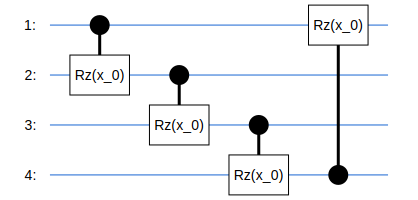

In [21]:
SVGCircuit(circuit)